In [3]:
import brainlit
from brainlit.utils.ngl_pipeline import NeuroglancerSession
from brainlit.viz.swc import *
from brainlit.algorithms.generate_fragments import adaptive_thresh

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/python_jsonschema_objects/__init__.py:53: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  self.schema["$schema"]


In [4]:
# Optional: Print the IDs of segments in Neuroglancer
url = "s3://mouse-light-viz/precomputed_volumes/brain1"
ngl_skel = NeuroglancerSession(url+"_segments", mip=1)
working_ids = []
for seg_id in range(10): #most segment IDs in range(300), additionally, segments 999, 1000 are available
    try:
        segment = ngl_skel.cv.skeleton.get(seg_id)
        working_ids.append(seg_id)
    except:
          pass
print(working_ids)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

[2, 7]


In [5]:
seg_id = 2
mip = 1
df = read_s3(url+"_segments", seg_id, mip)
#df.head()
df['sample'].size # the number of vertex IDs [1, 2, ..., df['sample'].size]

Downloading: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


1650

In [6]:
print(df)

      sample  structure       x       y       z    r  parent
0          1          0  4713.0  4470.0  3857.0  1.0      -1
1          4        192  4721.0  4445.0  3849.0  1.0       1
2          7         64  4723.0  4446.0  3851.0  1.0       4
3          8          0  4728.0  4449.0  3852.0  1.0       7
4         14          0  4746.0  4445.0  3858.0  1.0       8
...      ...        ...     ...     ...     ...  ...     ...
1645      97          0  4934.0  4111.0  3773.0  1.0      89
1646      96          0  4933.0  4145.0  3780.0  1.0      97
1647      92          0  4931.0  4189.0  3786.0  1.0      96
1648      82          0  4921.0  4206.0  3789.0  1.0      92
1649      77          0  4911.0  4236.0  3794.0  1.0      82

[1650 rows x 7 columns]


In [7]:
subneuron_df = df[0:5] # choose vertices to use for the subneuron
vertex_list = subneuron_df['sample'].array 
print(subneuron_df)
print(vertex_list)

   sample  structure       x       y       z    r  parent
0       1          0  4713.0  4470.0  3857.0  1.0      -1
1       4        192  4721.0  4445.0  3849.0  1.0       1
2       7         64  4723.0  4446.0  3851.0  1.0       4
3       8          0  4728.0  4449.0  3852.0  1.0       7
4      14          0  4746.0  4445.0  3858.0  1.0       8
<PandasArray>
[1, 4, 7, 8, 14]
Length: 5, dtype: int64


In [8]:
ngl = NeuroglancerSession(url, mip=mip)
buffer = [10, 10, 10]
img, bounds, vox_in_img_list = ngl.pull_vertex_list(seg_id, vertex_list, buffer = buffer, expand = True)

Downloading:   0%|          | 0/18 [00:05<?, ?it/s]


In [11]:
dataframe_new = generate_df_subset(subneuron_df, vox_in_img_list)

In [12]:
print(subneuron_df)
print(dataframe_new)
print(vox_in_img_list)

   sample  structure       x       y       z    r  parent
0       1          0  4713.0  4470.0  3857.0  1.0      -1
1       4        192  4721.0  4445.0  3849.0  1.0       1
2       7         64  4723.0  4446.0  3851.0  1.0       4
3       8          0  4728.0  4449.0  3852.0  1.0       7
4      14          0  4746.0  4445.0  3858.0  1.0       8
   sample  structure    x    y    z    r  parent
0       1          0  304   71  113  1.0      -1
1       4        192  299   12   93  1.0       1
2       7         64  335   89   71  1.0       4
3       8          0  222  253   61  1.0       7
4      14          0   46  550  104  1.0       8
[[304  71 113]
 [299  12  93]
 [335  89  71]
 [222 253  61]
 [ 46 550 104]]


In [10]:
# Reference: https://github.com/NeuroDataDesign/mouselit/blob/master/bijan/mouse_test/final%20notebook.ipynb

import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import napari


def plot_2d(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()

    if nda.ndim == 3:
        c = nda.shape[-1]

        if c not in (3, 4):
            nda = nda[nda.shape[0] // 2, :, :]

    elif nda.ndim == 4:
        c = nda.shape[-1]

        if c not in (3, 4):
            raise RuntimeError("Unable to show 3D-vector Image")

        nda = nda[nda.shape[0] // 2, :, :, :]

    xsize = nda.shape[1] * 2
    ysize = nda.shape[0] * 2

    figsize = (1 + margin) * xsize / dpi, (1 + margin) * ysize / dpi

    plt.figure(figsize=figsize, dpi=dpi, tight_layout=True)
    ax = plt.gca()

    extent = (0, xsize * spacing[0], ysize * spacing[1], 0)

    t = ax.imshow(nda, extent=extent, interpolation=None)

    if nda.ndim == 2:
        t.set_cmap("gray")

    if title:
        plt.title(title)

    plt.show()


def plot_3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05, dpi=80):
    img_xslices = [img[s, :, :] for s in xslices]
    img_yslices = [img[:, s, :] for s in yslices]
    img_zslices = [img[:, :, s] for s in zslices]

    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))

    img_null = sitk.Image([0, 0], img.GetPixelID(), img.GetNumberOfComponentsPerPixel())

    img_slices = []
    d = 0

    if len(img_xslices):
        img_slices += img_xslices + [img_null] * (maxlen - len(img_xslices))
        d += 1

    if len(img_yslices):
        img_slices += img_yslices + [img_null] * (maxlen - len(img_yslices))
        d += 1

    if len(img_zslices):
        img_slices += img_zslices + [img_null] * (maxlen - len(img_zslices))
        d += 1

    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen, d])
        else:
            img_comps = []
            for i in range(0, img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i) for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen, d]))
            img = sitk.Compose(img_comps)

    plot_2d(img, title, margin, dpi)


def napari_viewer(img, labels=None, shapes=None, label_name="Segmentation"):
    viewer = napari.view_image(np.squeeze(np.array(img)))
    if labels is not None:
        viewer.add_labels(labels, name=label_name)
    if shapes is not None:
        viewer.add_shapes(data=shapes, shape_type='path', edge_color='blue', name='Skeleton')
    return viewer

In [11]:
%gui qt5

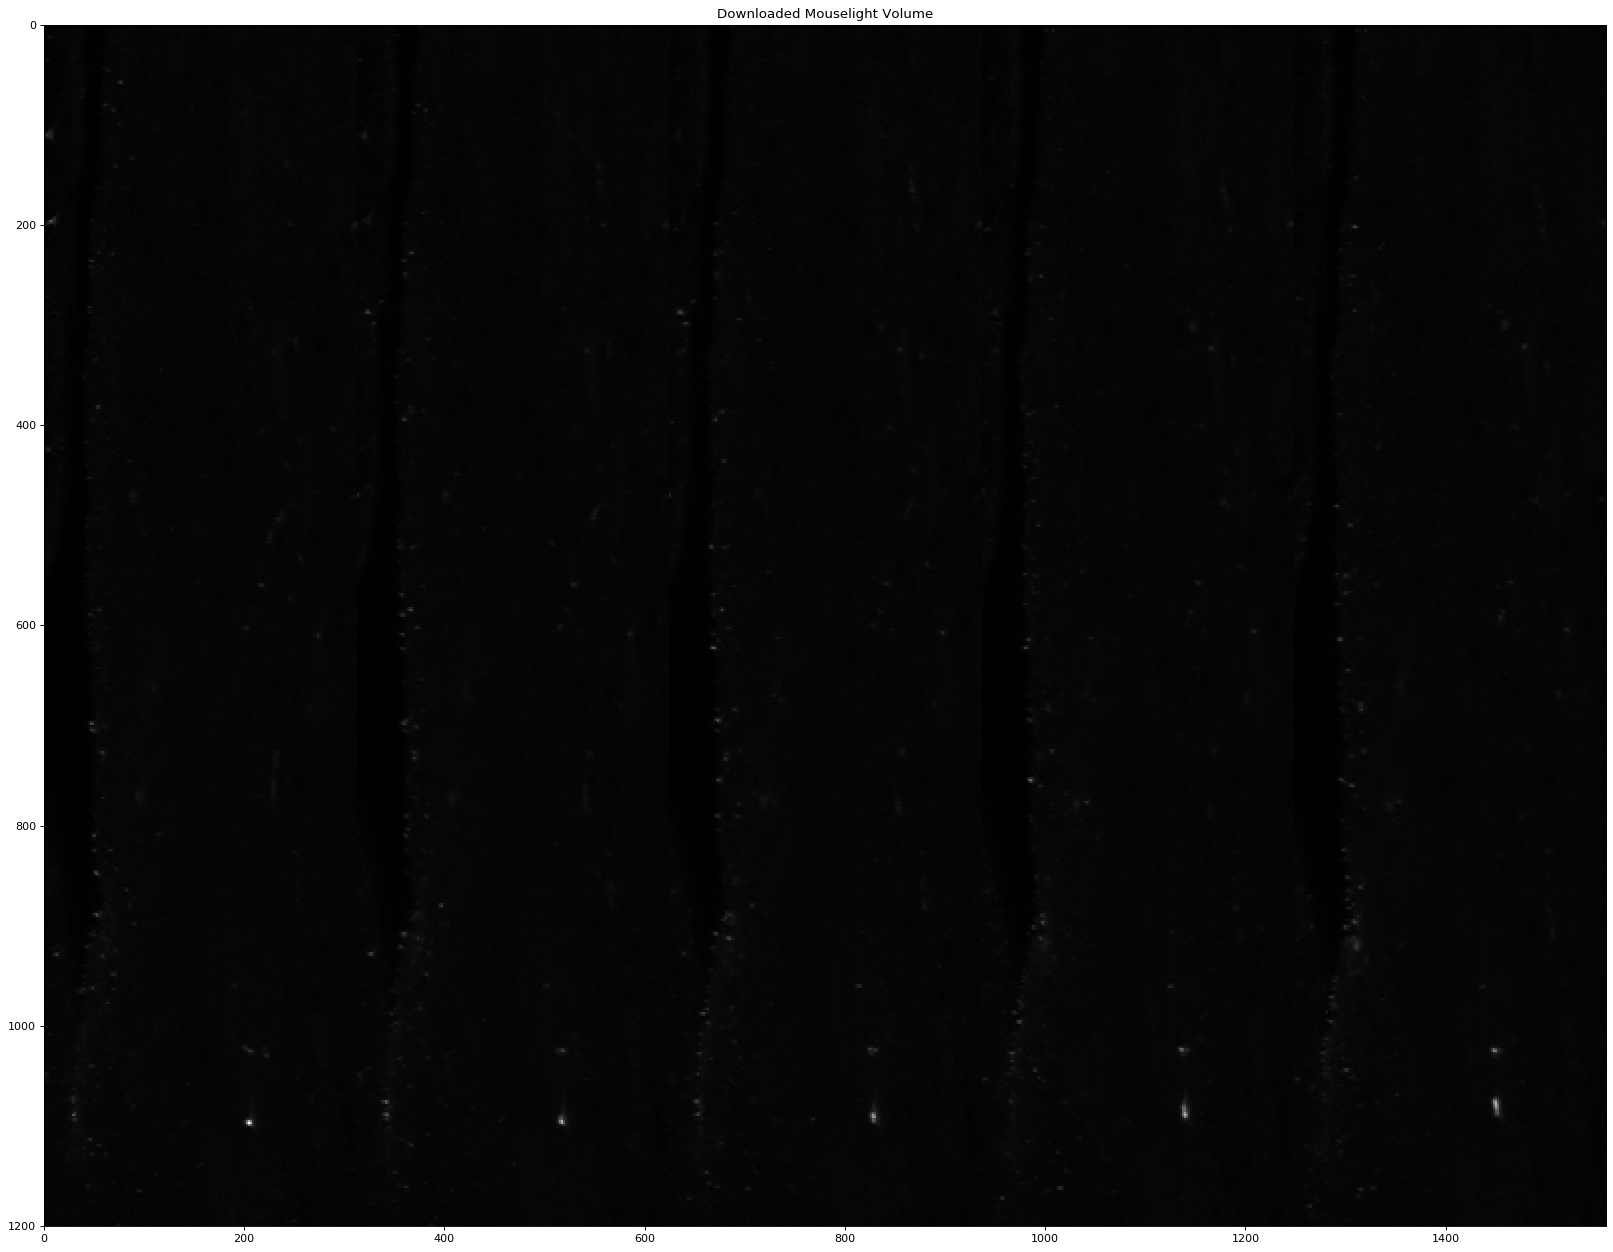

In [12]:
plot_3d(sitk.GetImageFromArray(np.squeeze(img), isVector=False), zslices=range(48,53), title = "Downloaded Mouselight Volume")

In [1]:
napari_viewer(img)

NameError: name 'napari_viewer' is not defined

In [13]:
G = df_to_graph(dataframe_new)
print('Number of nodes:', len(G.nodes))
print('Number of edges:', len(G.edges))
print('\n')
print('Sample 1 coordinates (x,y,z)')
G.nodes[1]

Number of nodes: 5
Number of edges: 4


Sample 1 coordinates (x,y,z)


{'x': 304, 'y': 71, 'z': 113}

In [14]:
paths = graph_to_paths(G)
len(paths)

1

In [15]:
%gui qt
napari_viewer(img, shapes=paths)

NameError: name 'napari_viewer' is not defined

In [16]:
seed = []
for sample in vox_in_img_list:
    _, s = adaptive_thresh.get_seed(sample)
    seed.append(s)
print(seed)

ValueError: too many values to unpack (expected 2)

In [37]:
print(img.shape)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
labels = adaptive_thresh.confidence_connected_threshold(img, seed, num_iter=1, multiplier=0.3)

Exception: Wrong number of arguments, coordinates arguments then value

In [ ]:
## Most useful visualization cell - contains image, SWC, and automatic segmentation
%gui qt
napari_viewer(img, labels=labels, shapes=paths, label_name="Confidence-Connected Threshold")